# 4-7. 3D記述子やフィンガープリントに基づく回帰予測 †
4-5. や 4-6. で行ったものと同じものを、3D記述子およびECFP4 fingerprintでも実施せよ。

In [1]:
import pandas as pd

desc_3d = pd.read_csv("data/3d_desc.csv", index_col=0)
df = pd.read_csv("data/fukunishi_data.csv", index_col=0)

In [2]:
# 説明変数に 2D記述子 を利用
X = desc_3d
 
# 目的変数に "Logp App" を利用
Y = df["LogP app"]

In [3]:
from sklearn.preprocessing import StandardScaler

#　標準化
scaler = StandardScaler()
X_norm = scaler.fit_transform(X)

## SVR

In [4]:
from sklearn.svm import SVR

from hyper_params import grid
from calc_score import regression


params = {
    'C': [0.001, 0.01, 0.1, 1, 10],
    'gamma':  [0.001, 0.01, 0.1, 1],
}
svr = SVR(kernel='linear')
# regression(svr, X_norm, Y)
gs = grid(X_norm, Y, params, svr)

/Users/kaz_i/.pyenv/versions/miniconda3-4.3.30/envs/py36/lib/python3.6/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function cpu_count is deprecated; deprecated in version 0.20.1 to be removed in version 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib.
  warnings.warn(msg, category=FutureWarning)


{'C': 10, 'gamma': 0.001}


best rmse: 0.88897
q2: 0.37898


SVR(C=10, cache_size=200, coef0=0.0, degree=3, epsilon=0.1, gamma=0.001,
    kernel='linear', max_iter=-1, shrinking=True, tol=0.001, verbose=False)

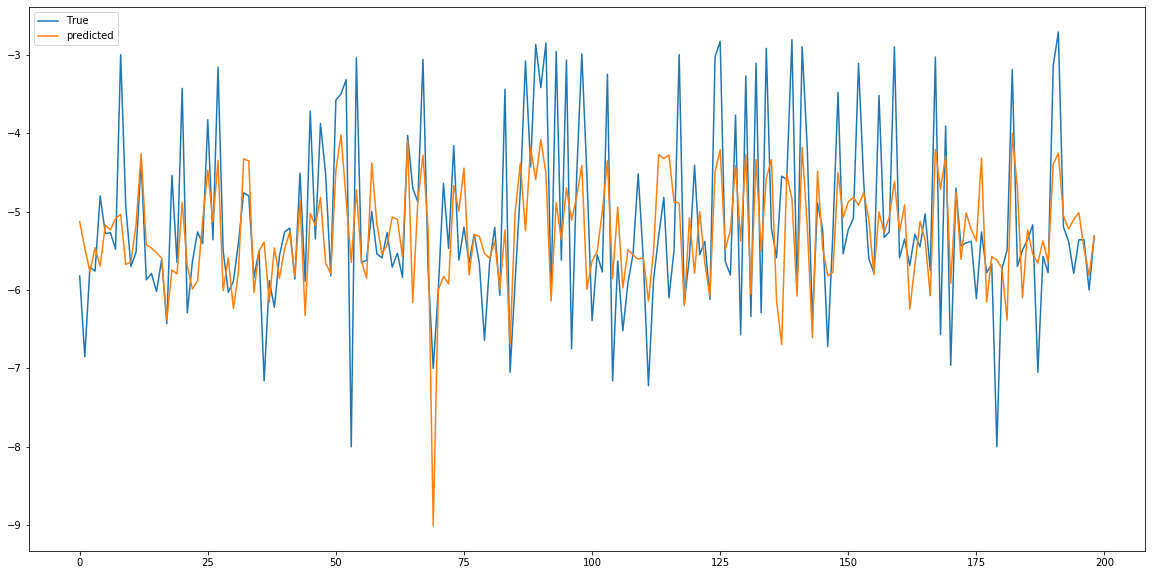

In [6]:
svr_b = SVR(kernel='linear', **gs.best_params_)

regression(svr_b, X_norm, Y, graph=True)

## lightGBM

In [7]:
import lightgbm as lgb

param_grid = {"max_depth": [10, 25, 50, 75],
              "learning_rate" : [0.001,0.01,0.05,0.1],
              "num_leaves": [100,300,900,1200],
              "n_estimators": [100,200,500]
             }

lgb_reg = lgb.LGBMRegressor()
gs = grid(X_norm, Y, param_grid, lgb_reg)

/Users/kaz_i/.pyenv/versions/miniconda3-4.3.30/envs/py36/lib/python3.6/site-packages/lightgbm/__init__.py:48: UserWarning: Starting from version 2.2.1, the library file in distribution wheels for macOS is built by the Apple Clang (Xcode_8.3.3) compiler.
This means that in case of installing LightGBM from PyPI via the ``pip install lightgbm`` command, you don't need to install the gcc compiler anymore.
Instead of that, you need to install the OpenMP library, which is required for running LightGBM on the system with the Apple Clang compiler.
You can install the OpenMP library by the following command: ``brew install libomp``.
  "You can install the OpenMP library by the following command: ``brew install libomp``.", UserWarning)
/Users/kaz_i/.pyenv/versions/miniconda3-4.3.30/envs/py36/lib/python3.6/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function cpu_count is deprecated; deprecated in version 0.20.1 to be removed in version 0.23. Please import this functionality dire

{'learning_rate': 0.05, 'max_depth': 25, 'n_estimators': 100, 'num_leaves': 100}


best rmse: 0.61976
q2: 0.71376


LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
              importance_type='split', learning_rate=0.05, max_depth=25,
              min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
              n_estimators=100, n_jobs=-1, num_leaves=100, objective=None,
              random_state=None, reg_alpha=0.0, reg_lambda=0.0, silent=True,
              subsample=1.0, subsample_for_bin=200000, subsample_freq=0)

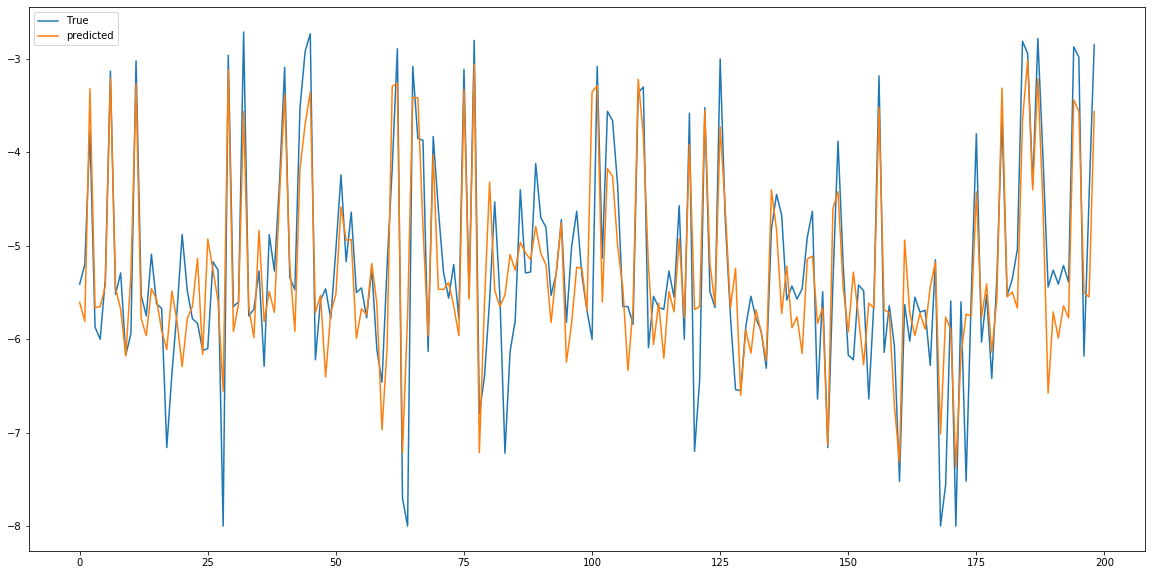

In [8]:
lgb_reg = lgb.LGBMRegressor(**gs.best_params_)
regression(lgb_reg, X_norm, Y, graph=True)

## optuna

In [18]:
import optuna

from calc_score import calc_rmse

def objective(X, y, trial):
    params = {
        'max_depth': trial.suggest_int('max_depth', 1, 1e+2),
        'learning_rate': trial.suggest_loguniform("learning_rate", 1e-4, 1),
        'num_leaves': trial.suggest_int("num_leaves", 1e+2, 1e+4),
        "n_estimators": trial.suggest_int("n_estimators", 1e+2, 1e+3),
    }
    model_opt = lgb.LGBMRegressor(**params)
    
    kf = KFold(n_splits=4, shuffle=True, random_state=42)   
    y_pred = cross_val_predict(model_opt, X, y, cv=kf)
    return calc_rmse(y, y_pred)

In [20]:
from functools import partial
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import KFold



study_rmse = optuna.create_study(direction='minimize')
f = partial(objective, X, Y)
study_rmse.optimize(f, n_trials=10)
study_rmse.best_params

[I 2020-04-07 20:08:22,257] Finished trial#0 with value: 0.8424601123971202 with parameters: {'max_depth': 70, 'learning_rate': 0.0009671231566657988, 'num_leaves': 2445, 'n_estimators': 554}. Best is trial#0 with value: 0.8424601123971202.
[I 2020-04-07 20:08:26,409] Finished trial#1 with value: 0.7098973168706307 with parameters: {'max_depth': 67, 'learning_rate': 0.35120515740660524, 'num_leaves': 8642, 'n_estimators': 514}. Best is trial#1 with value: 0.7098973168706307.
[I 2020-04-07 20:08:29,963] Finished trial#2 with value: 0.6665616929988363 with parameters: {'max_depth': 30, 'learning_rate': 0.055805549740318795, 'num_leaves': 6789, 'n_estimators': 467}. Best is trial#2 with value: 0.6665616929988363.
[I 2020-04-07 20:08:31,464] Finished trial#3 with value: 0.7016260335043152 with parameters: {'max_depth': 73, 'learning_rate': 0.5347571820608983, 'num_leaves': 2072, 'n_estimators': 453}. Best is trial#2 with value: 0.6665616929988363.
[I 2020-04-07 20:08:33,833] Finished trial

{'max_depth': 28,
 'learning_rate': 0.006807595464341603,
 'num_leaves': 8545,
 'n_estimators': 494}

best rmse: 0.72507
q2: 0.63203


LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
              importance_type='split', learning_rate=0.006807595464341603,
              max_depth=28, min_child_samples=20, min_child_weight=0.001,
              min_split_gain=0.0, n_estimators=494, n_jobs=-1, num_leaves=8545,
              objective=None, random_state=None, reg_alpha=0.0, reg_lambda=0.0,
              silent=True, subsample=1.0, subsample_for_bin=200000,
              subsample_freq=0)

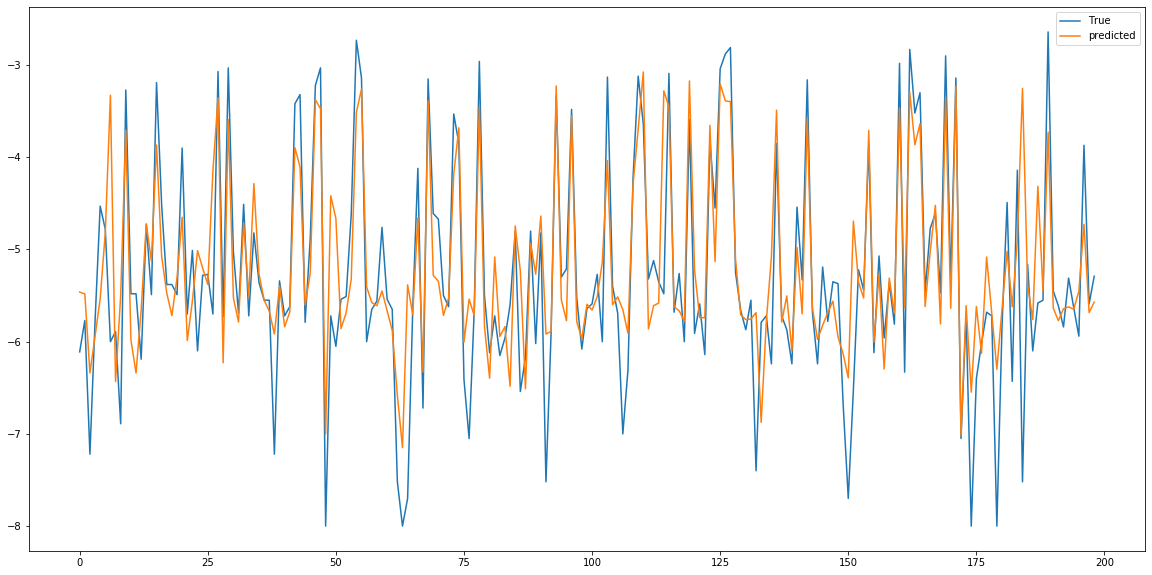

In [22]:
f_model = lgb.LGBMRegressor(**study_rmse.best_params)
regression(f_model, X, Y, graph=True)